In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from tqdm import tqdm

# GBM with correlated components

In [17]:
def simulate_stock_prices(
        stockData:pd.DataFrame, 
        mc_sims:int, 
        time_periods:int, 
        dt=1.0
        ) -> np.ndarray:
    """
    Arguments
    ----------
    stocksData : pd.DataFrame
        DataFrame with stock Close prices,
    mc_sims : int
        number of trajectories to simulate
    time_periods : int
        number of periods to predict
    dt : flaot
        equals to 1 by default as mean return and covarince matrix is calculated inside the function

    Returns
    -------
    price_predict : np.nparray(mc_sims, stock_number, time_periods)
        a np.ndarray with predicted prices, the 0-th is the last Close price
    """
    global stocks_number, stock_tickers
    returns = stockData.pct_change()
    meanReturns = returns.mean().values
    covMatrix = returns.cov().values
    corrMatrix = returns.corr().values

    stocks_number = covMatrix.shape[0]
    stock_tickers = list(stockData.columns.values)

    prices_predicted = np.zeros(shape=(mc_sims, stocks_number, time_periods+1))
    #generating various trajectories
    for m in tqdm(range(0, mc_sims)):
        Z = np.random.normal(size=(time_periods, stocks_number))
        L = np.linalg.cholesky(corrMatrix)
        Z_corr = np.dot(L, Z.T).T
        for stock_number in range(stocks_number):
            #zero index stands for now(it isn't predicted)
            prices_predicted[m, stock_number, 0] = stockData.iloc[-1, stock_number]
            for time in range(1, time_periods+1):
                prices_predicted[m, stock_number, time] = prices_predicted[m, stock_number, time - 1] * np.exp(
                (meanReturns[stock_number] - 0.5 * covMatrix[stock_number, stock_number]) * dt + np.sqrt(covMatrix[stock_number, stock_number]) * Z_corr[time - 1, stock_number] * np.sqrt(dt)
                )
    return prices_predicted

In [18]:
def get_Data(stocks_tickers, start, end, interval):
    stockData = yf.download(stocks_tickers, start=start, end=end, interval=interval)
    stockData = stockData['Close']
    return stockData

In [19]:
stockData = get_Data(['AAPL', 'GOOG', '^GSPC', 'TSLA', 'IBM'], 
                                            start = '2011-01-01',
                                            end='2023-11-30',
                                            interval='1mo')
stockData

[*********************100%%**********************]  5 of 5 completed


,AAPL,GOOG,IBM,TSLA,^GSPC
Date,,,,,
2011-01-01,12.118571,14.952953,154.875717,1.606667,1286.119995
2011-02-01,12.614643,15.277735,154.761002,1.592667,1327.219971
2011-03-01,12.446786,14.614222,155.898666,1.850000,1325.829956
2011-04-01,12.504643,13.551705,163.078400,1.840000,1363.609985
2011-05-01,12.422500,13.176113,161.500961,2.009333,1345.199951
...,...,...,...,...,...
2023-07-01,196.449997,133.110001,144.179993,267.429993,4588.959961
2023-08-01,187.869995,137.350006,146.830002,258.079987,4507.660156
2023-09-01,171.210007,131.850006,140.300003,250.220001,4288.049805


In [20]:
prices_predicted = simulate_stock_prices(
    stockData=stockData,
    mc_sims=5_000,
    time_periods=12*20,
    dt=1.0
)

100%|██████████| 5000/5000 [00:19<00:00, 261.17it/s]


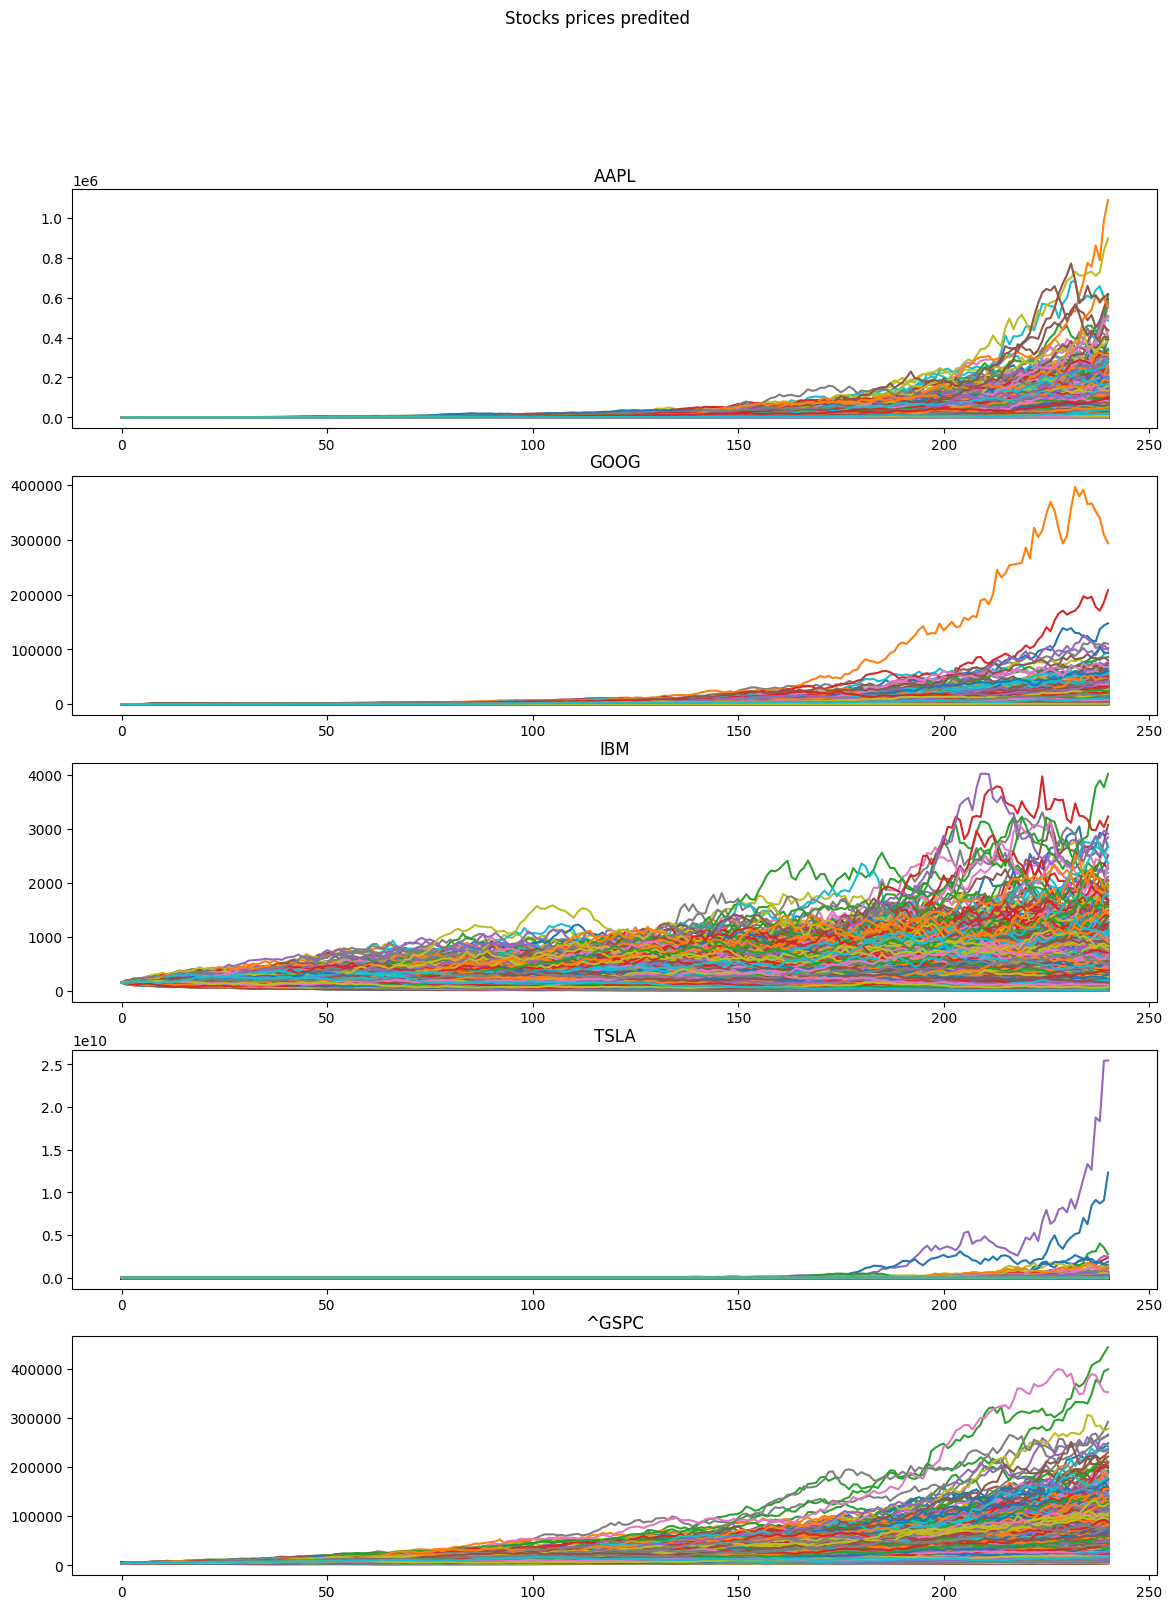

In [21]:
fig, axs = plt.subplots(stocks_number)
fig.set_size_inches(14, 18)
fig.suptitle('Stocks prices predited')
for stock_number in range(stocks_number):
    axs[stock_number].set_title(stock_tickers[stock_number])
    axs[stock_number].plot(prices_predicted[:, stock_number, :].T)

In [22]:
def simulate_stock_quantile_prices(
        prices_predicted:np.array, 
        alpha:float
        )-> np.ndarray:
    """
    Arguments
    ----------
    prices_predicted:np.ndarray
        Prices that have been predicted with simulate_stock_prices function
    alpha:float
        alpha-th 

    Returns
    -------
    quntile_price_predict : np.nparray(stock_number, time_periods)
        np.ndarray with predicted quntile of prices, the 0-th is the last Close price
    """
    return np.quantile(prices_predicted, axis=0, q=alpha)

In [23]:
predicted_quantile_prices = simulate_stock_quantile_prices(
    prices_predicted,
    alpha = 0.5)

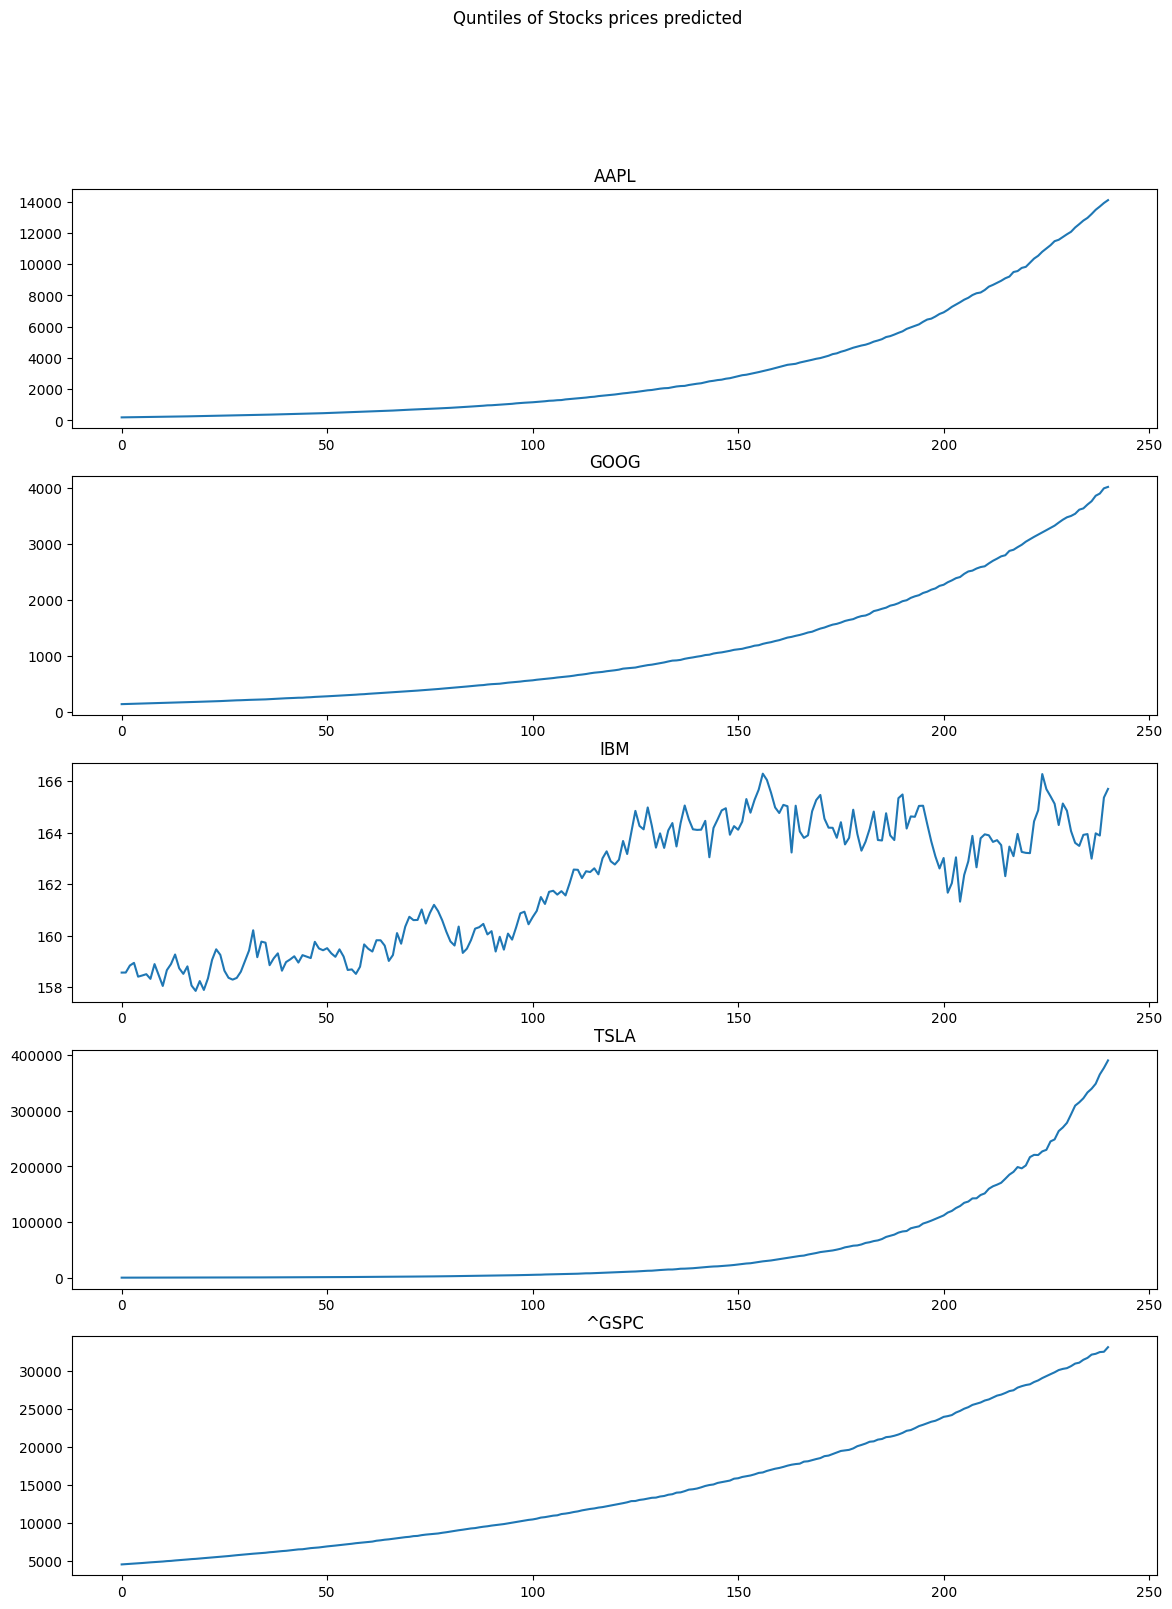

In [24]:
fig, axs = plt.subplots(stocks_number)
fig.set_size_inches(14, 18)
fig.suptitle('Quntiles of Stocks prices predicted')
for stock_number in range(stocks_number):
    axs[stock_number].set_title(stock_tickers[stock_number])
    axs[stock_number].plot(predicted_quantile_prices [stock_number, :].T)